In [1]:
%pip install opencv-python scikit-image pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog

%matplotlib inline
plt.style.use("seaborn-v0_8")


In [3]:
import os

# Get the absolute path of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # fallback for scripts
try:
    import ipynbname
    notebook_dir = os.path.dirname(ipynbname.path())
except:
    pass  # continue with __file__-based guess

# Go two levels up and into "data" folder
base_path = os.path.abspath(os.path.join(notebook_dir, "..", "..", "data"))

# Sanity checks
print("Resolved dataset path:", base_path)
if not os.path.isdir(base_path):
    raise FileNotFoundError(f"Could not find data directory at: {base_path}")
if not os.path.isdir(os.path.join(base_path, "train")) or not os.path.isdir(os.path.join(base_path, "test")):
    raise FileNotFoundError(f"'train' and/or 'test' folder missing inside: {base_path}")


Resolved dataset path: c:\computervision\cv25-group05\data


In [4]:
def count_images_per_emotion(folder_path):
    counts = defaultdict(int)
    for emotion in os.listdir(folder_path):
        emotion_path = os.path.join(folder_path, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return dict(counts)

train_counts = count_images_per_emotion(os.path.join(base_path, "train"))
test_counts = count_images_per_emotion(os.path.join(base_path, "test"))

print("Image count in training set:")
print(train_counts)

print("\nImage count in test set:")
print(test_counts)


Image count in training set:
{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}

Image count in test set:
{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


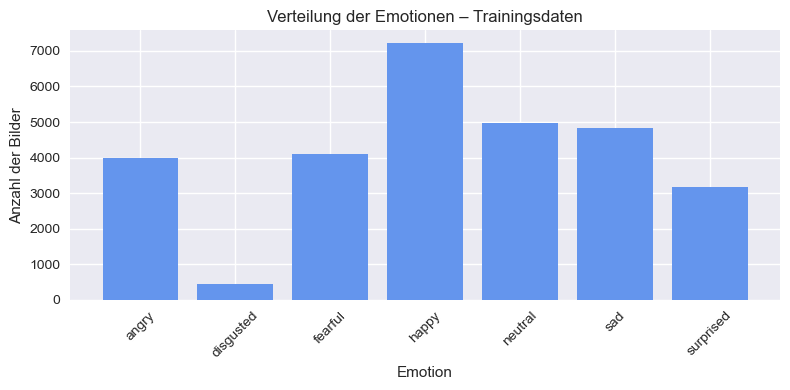

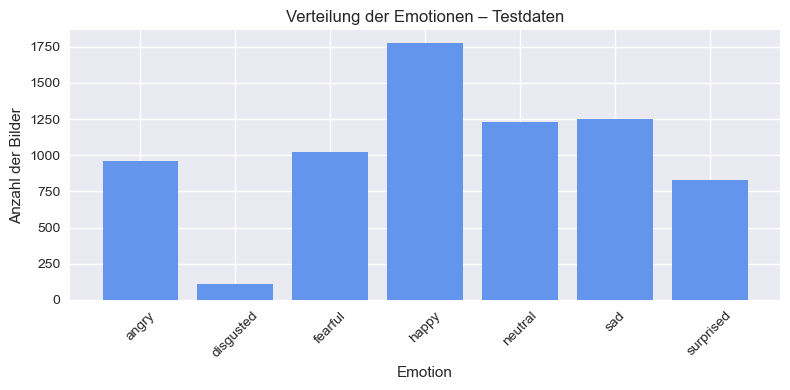

In [5]:
# Diagram of all the emotions
def plot_emotionen(daten, titel):
    plt.figure(figsize=(8, 4))
    plt.bar(daten.keys(), daten.values(), color="cornflowerblue")
    plt.title(titel)
    plt.xlabel("Emotion")
    plt.ylabel("Anzahl der Bilder")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Show training and test data
plot_emotionen(train_counts, "Verteilung der Emotionen – Trainingsdaten")
plot_emotionen(test_counts, "Verteilung der Emotionen – Testdaten")

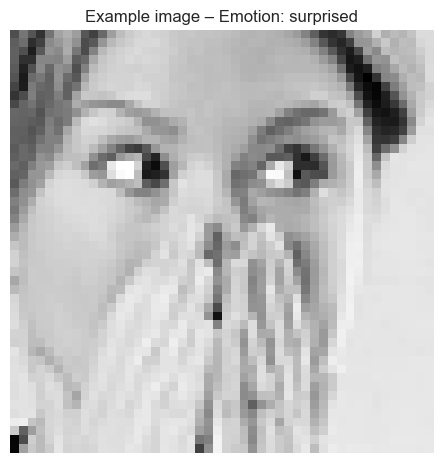

Image resolution: (48, 48)


In [6]:
# Choose example image
image_path = os.path.join(base_path, "train", "surprised", "im99.png")

# Read image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Show image
plt.imshow(image, cmap="gray")
plt.title("Example image – Emotion: surprised")
plt.axis("off")
plt.show()

# Show image resolution
print(f"Image resolution: {image.shape}")


In [7]:
# Function: returns frequency of image resolutions
def analyze_image_shapes(folder_path):
    shapes = []
    for emotion in os.listdir(folder_path):
        emotion_path = os.path.join(folder_path, emotion)
        for filename in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                shapes.append(image.shape)
    return pd.Series(shapes).value_counts()

# Analyze training set image sizes
print("Image size frequency in training dataset:")
print(analyze_image_shapes(os.path.join(base_path, "train")))


Image size frequency in training dataset:
(48, 48)    28709
Name: count, dtype: int64


In [8]:
# Get emotion labels from the folder names
emotion_labels = sorted(os.listdir(os.path.join(base_path, "train")))
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

def load_images_and_labels(base_folder):
    images = []
    labels = []
    for emotion in emotion_labels:
        folder = os.path.join(base_folder, emotion)
        for filename in os.listdir(folder):
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠️ Could not read image: {path}")
                continue
            try:
                img = cv2.resize(img, (48, 48))
                images.append(img)
                labels.append(label_mapping[emotion])
            except Exception as e:
                print(f"⚠️ Failed to process {path}: {e}")
    return np.array(images), np.array(labels)

X_train_images, y_train = load_images_and_labels(os.path.join(base_path, "train"))
X_test_images, y_test = load_images_and_labels(os.path.join(base_path, "test"))


In [9]:
def extract_sobel_features(image_array):
    features = []
    for img in image_array:
        # Apply Sobel filter in x and y directions
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        # Compute magnitude of gradient
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        
        # Flatten the magnitude to a 1D feature vector
        features.append(magnitude.flatten())
        
    return np.array(features)


X_train_sobel = extract_sobel_features(X_train_images)
X_test_sobel = extract_sobel_features(X_test_images)


In [10]:
print(f"Sobel feature shape: {X_train_sobel.shape}")
print(f"Number of labels: {y_train.shape}")

subset_size = min(10000, len(X_train_sobel))

if subset_size == 0:
    raise ValueError("No training data found. Make sure images were loaded and Sobel features were extracted correctly.")

X_train_sobel, y_train = shuffle(X_train_sobel, y_train, random_state=42)
X_train_subset = X_train_sobel[:subset_size]
y_train_subset = y_train[:subset_size]


# Train SVM
model = SVC(kernel='linear', probability=True)
model.fit(X_train_subset, y_train_subset)


Sobel feature shape: (28709, 2304)
Number of labels: (28709,)


SVC(kernel='linear', probability=True)

Accuracy: 0.26776260796879353

Classification Report:

              precision    recall  f1-score   support

       angry       0.18      0.27      0.21       958
   disgusted       0.11      0.16      0.13       111
     fearful       0.18      0.23      0.21      1024
       happy       0.40      0.37      0.38      1774
     neutral       0.27      0.23      0.25      1233
         sad       0.23      0.15      0.18      1247
   surprised       0.40      0.32      0.36       831

    accuracy                           0.27      7178
   macro avg       0.25      0.25      0.25      7178
weighted avg       0.28      0.27      0.27      7178



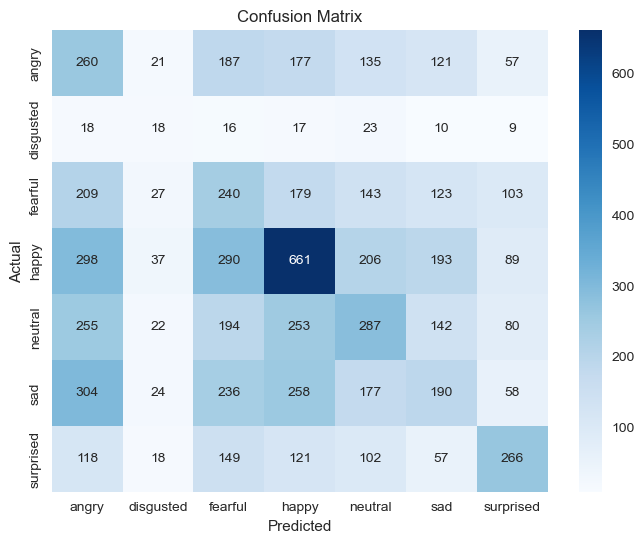

In [11]:
y_pred = model.predict(X_test_sobel)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
